In [ ]:
!pip install numpy==1.23.5
!pip install surprise
!pip install scikit-surprise --no-cache-dir

In [ ]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

In [ ]:
Movies = pd.read_csv('/content/movies.csv')
Ratings = pd.read_csv('/content/ratings.csv')

In [ ]:
Movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
Movies.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
Movies['movieId'].nunique()

9742

In [ ]:
Ratings.head(10)

,userId,movieId,rating,date
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
5,1,70,3.0,2000-07-30 18:40:00
6,1,101,5.0,2000-07-30 18:14:28
7,1,110,4.0,2000-07-30 18:36:16
8,1,151,5.0,2000-07-30 19:07:21
9,1,157,5.0,2000-07-30 19:08:20


In [ ]:
df = Ratings.merge(Movies, on = 'movieId')
df.head(10)

,userId,movieId,rating,date,title,genres
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,2000-07-30 18:40:00,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,2000-07-30 18:14:28,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,2000-07-30 18:36:16,Braveheart (1995),Action|Drama|War
8,1,151,5.0,2000-07-30 19:07:21,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,2000-07-30 19:08:20,Canadian Bacon (1995),Comedy|War


In [ ]:
df_processed = df.copy()

In [ ]:
df_processed.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [ ]:
df_processed.isnull().sum()

,0
userId,0
movieId,0
rating,0
date,0
title,0
genres,0


In [ ]:
df_processed.duplicated().sum()

0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-28-57f55dfd5ee0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='coolwarm')


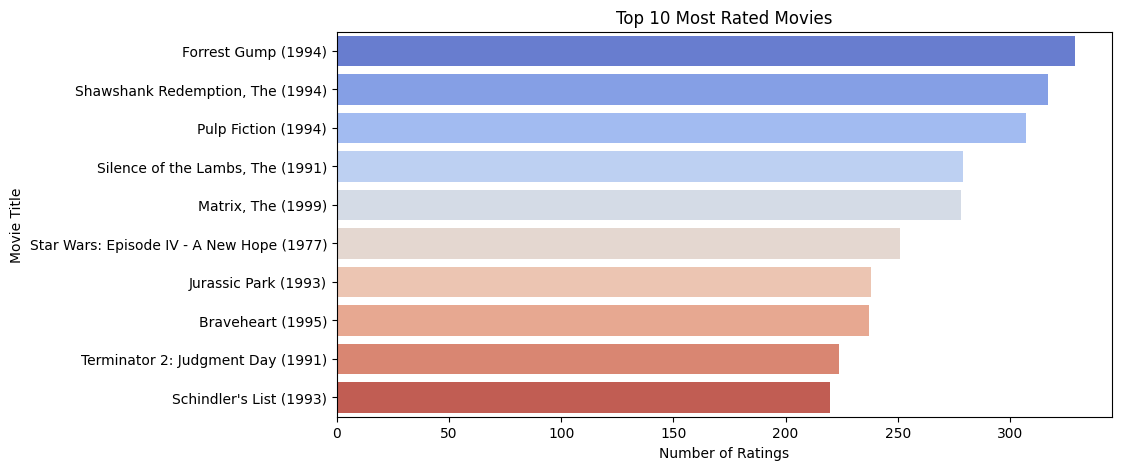

In [ ]:
top_movies = df['title'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='coolwarm')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Most Rated Movies')
plt.show()

<ipython-input-29-62b752d53ce4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_avg_rating.values, y=genre_avg_rating.index, palette='viridis')


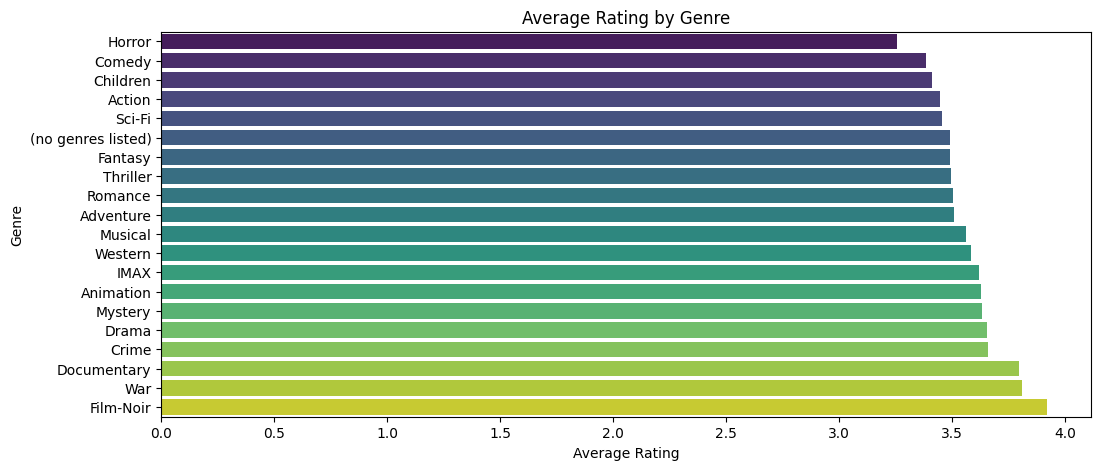

In [ ]:
df_exploded = df.assign(genres=df['genres'].str.split('|')).explode('genres')
genre_avg_rating = df_exploded.groupby('genres')['rating'].mean().sort_values()

plt.figure(figsize=(12, 5))
sns.barplot(x=genre_avg_rating.values, y=genre_avg_rating.index, palette='viridis')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Rating by Genre')
plt.show()

In [ ]:
S = Reader(rating_scale=(0.5,5))
Data = Dataset.load_from_df(df_processed[['userId', 'movieId', 'rating']], S)

trainset, testset = train_test_split(Data, test_size=0.20)

#Dataset splitting
trainset, testset = train_test_split(Data, test_size=0.2)

# Train model
model = SVD()
model.fit(trainset)

# Test model
predictions = model.test(testset)
rmse = accuracy.rmse(predictions, verbose = False)
print(f"Model RMSE: {rmse:.4f}")

Model RMSE: 0.8787


### What is Reader in Simple Terms?
Think of Reader as a translator that helps a recommendation system understand the ratings in your dataset.

Imagine you are a teacher collecting movie ratings from students. Some students rate movies from 1 to 5, while others use 0 to 10. If you want to compare their ratings, you need to tell your system what the minimum and maximum ratings are—this is exactly what Reader does!

###  Why Do We Need Reader?
Let’s say you have a table of movie ratings:

User ID	Movie ID	Rating
1	101	5.0
2	203	4.5
3	309	3.0
If the system doesn’t know how ratings are given, it might think:

"Is 5.0 the highest rating or does it go up to 10?"

"Are 0.5 ratings allowed, or is it whole numbers only?"

"Can ratings be negative?"

To avoid confusion, we use Reader to tell the system:
📢 "Hey! The ratings in this dataset go from 0.5 to 5!"

###Why Only Three Columns?

1️⃣Collaborative Filtering Only Needs User-Item-Rating Data
Surprise focuses on collaborative filtering, which works by analyzing patterns in user ratings rather than additional metadata like timestamps or movie genres.

The model learns how users interact with items, assuming similar users have similar preferences.

Extra information like genres or timestamps isn't directly needed for the matrix factorization models Surprise is optimized for.

2️⃣ Internal Data Representation (Trainset & Matrix Factorization)
When Surprise loads the data using Dataset.load_from_df(df, reader), it internally converts it into a sparse matrix where:

Rows = Users

Columns = Items (movies, books, products, etc.)

Values = Ratings (0.5 to 5.0, etc.)

Since collaborative filtering only needs this matrix, extra columns (e.g., timestamp, genre) are not required.

In [ ]:
def get_estimated_rating(prediction):
    "Helper function to extract the estimated rating from a prediction object."
    return prediction.est

def recommend_movies(user_id, model, df, movies, n):
    """
    Recommend top N movies for a user using real-time predictions from SVD model.

    """
    all_movie_ids = movies['movieId'].unique()  # Get all movies
    watched_movies = df[df['userId'] == user_id]['movieId'].values  # Movies the user has seen
    unseen_movies = [m for m in all_movie_ids if m not in watched_movies]  # Movies not seen

    # Predict ratings dynamically
    predictions = [model.predict(user_id, movie) for movie in unseen_movies]

    # Sort movies by highest predicted rating (using a function instead of lambda)
    predictions = sorted(predictions, key=get_estimated_rating, reverse=True)

    # Get top N recommended movie IDs
    top_movie_ids = [p.iid for p in predictions[:n]]

    ranked_movies = pd.DataFrame({'movieId': top_movie_ids})  # Keep the sorted order
    return ranked_movies.merge(movies, on='movieId', how='left')  # Merge to get movie details

# Example: Recommend movies for User 1
recommend_movies(1, model, df, Movies, 5)


,movieId,title,genres
0,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
1,899,Singin' in the Rain (1952),Comedy|Musical|Romance
2,912,Casablanca (1942),Drama|Romance
3,1035,"Sound of Music, The (1965)",Musical|Romance
4,1204,Lawrence of Arabia (1962),Adventure|Drama|War
